# HM1: Logistic Regression.

### Name: Ethan Kalika


#### For this assignment, you will build 6 models. You need to train Logistic Regression/Regularized Logistic Regression each with Batch Gradient Descent, Stochastic Gradient Descent and Mini Batch Gradient Descent. Also you should plot their objective values versus epochs and compare their training and testing accuracies. You will need to tune the parameters a little bit to obtain reasonable results.

#### You do not have to follow the following procedure. You may implement your own functions and methods, but you need to show your results and plots.

In [194]:
# Load Packages
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

# 1. Data processing

- Download the Breast Cancer dataset from canvas or from https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)
- Load the data.
- Preprocess the data.

## 1.1. Load the data

In [195]:
cwd = os.getcwd()
dataPath = cwd + "/DataFolder/wdbc.data"
bcDataList = []
with open(dataPath, 'r') as file:
    bcDataList = [line.strip().split(',') for line in file]

## 1.2 Examine and clean data

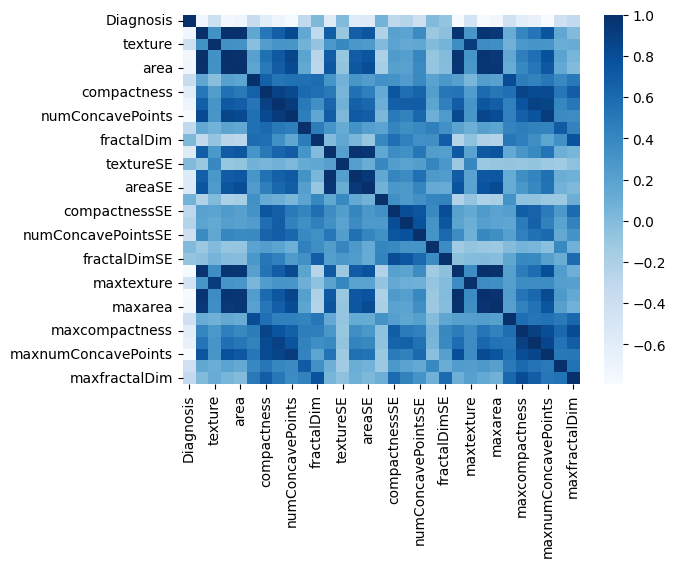

In [196]:
# Some columns may not be useful for the model (For example, the first column contains ID number which may be irrelavant). 
# You need to get rid of the ID number feature.
# Also you should transform target labels in the second column from 'B' and 'M' to 1 and -1.

# Creation of Data Frame
featAndLab = ["ID", "Diagnosis", "radius", "texture", "perimiter", "area", "smoothness", "compactness", "concavity", "numConcavePoints", "symmetry", "fractalDim", "radiusSE", "textureSE", "perimiterSE", "areaSE", "smoothnessSE", "compactnessSE", "concavitySE", "numConcavePointsSE", "symmetrySE", "fractalDimSE", "maxradius", "maxtexture", "maxperimiter", "maxarea", "maxsmoothness", "maxcompactness", "maxconcavity", "maxnumConcavePoints", "maxsymmetry", "maxfractalDim"]
bcData = pd.DataFrame(bcDataList, columns = featAndLab)

# Changing of Diagnosis column to 1 and -1
for val in range(bcData.shape[0]):
    if bcData.at[val, 'Diagnosis'] == "M":
        bcData.at[val, 'Diagnosis'] = -1
    else:
        bcData.at[val, 'Diagnosis'] = 1

# Casting of all entries to integers
bcData = bcData.apply(pd.to_numeric, errors='coerce')

# Drops the ID column
bcData = bcData.drop(columns = ["ID"])

# Creation of correlation heat map
sns.heatmap(bcData.corr(), cmap = "Blues")
plt.show()

## 1.3. Partition to training and testing sets

In [197]:
# You can partition using 80% training data and 20% testing data. It is a commonly used ratio in machinel learning.
x = bcData[featAndLab[2:]]
y = bcData["Diagnosis"]
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 73, test_size = 0.2, shuffle = True)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

## 1.4. Feature scaling

Use the standardization to trainsform both training and test features

In [198]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[ 0.16635018  0.10402813  0.15840459  0.15322177 -0.07282959  0.01708285
  0.02723534  0.06754009 -0.09845091 -0.04980712 -0.005869   -0.15333624
 -0.02485607  0.00820606 -0.14018636 -0.06173525 -0.01014355  0.03935855
 -0.06659258  0.00704414  0.17082776  0.06840659  0.15710509  0.16531538
 -0.02856111  0.00436692  0.03591625  0.12141359 -0.02383901 -0.01497693]
test std = 
[1.01610236 1.11627081 1.0075766  1.04303315 1.0538335  0.96037483
 0.89631445 0.96145949 0.92101431 1.07966823 0.81034287 0.9200947
 0.77418414 0.73280257 0.79659717 0.96691626 1.08921979 0.93681946
 0.94276405 1.14341913 1.0703033  1.1154803  1.05899324 1.14029193
 0.96216767 0.95034751 0.9709453  0.99607602 1.01520321 0.95186295]


# 2.  Logistic Regression Model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

When $\lambda = 0$, the model is a regular logistric regression and when $\lambda > 0$, it essentially becomes a regularized logistric regression.

In [199]:
# Calculate the objective function value, or loss
# Inputs:
#     w: weight: d-by-1 vector
#     x: data: n-by-d matrix
#     y: label: n-by-1 vector
#     lam: regularization parameter: scalar
# Return:
#     objective function value, or loss (scalar)
def objective(w, x, y, lam):
    sum = 0
    n = len(x)
    for i in range(0, n):
        sum = sum + np.log(1 + np.exp(-1 * y[i] * np.dot(x[i].T, w)))
    sum = sum / n
    sum = sum + (numpy.dot(w.T, w) * lam / 2)
    return sum

#objective(np.array([1, 2, 3]), np.array([np.array([0, 2, 3]), np.array([4, 5, 6]), np.array([7, 8, 9]), np.array([0, 1, 2])]), np.array([1, -1, -1, 1]), 0.5)

# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ for regularized logistic regression is  $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [200]:
# Calculate the gradient
# Inputs:
#     w: weight: d-by-1 matrix
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: regularization parameter: scalar
# Return:
#     g: gradient: d-by-1 matrix

def gradient(w, x, y, lam):
    sum = 0 
    n = len(x)
    for i in range(0, n):
        den = (1 + numpy.exp(y[i] * numpy.dot(x[i].T, w)))
        num = (y[i] * x[i])
        sum -= (num / den)
    sum = sum / n
    sum = sum.reshape((30,1)) + lam * w
    return sum

# result = gradient(np.array([1, 2, 3]), np.array([np.array([0, 2, 3]), np.array([4, 5, 6]), np.array([7, 8, 9]), np.array([0, 1, 2])]), np.array([1, -1, -1, 1]), 0.5)

In [202]:
# Gradient descent for solving logistic regression
# You will need to do iterative process (loops) to obtain optimal weights in this function

# Inputs:
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     learning_rate: scalar
#     w: weights: d-by-1 vector, initialization of w
#     max_epoch: integer, the maximal epochs
# Return:
#     w: weights: d-by-1 vector, the solution
#     objvals: a record of each epoch's objective value

def gradient_descent(x, y, lam, learning_rate, w, max_epoch=100):
    weights = []
    objVals = []
    for i in range(0, max_epoch):
        w = w - (learning_rate * gradient(w, x, y, lam))
        objVals = objVals + [objective(w, x, y, lam)]
        weights = weights + [w]
    return weights, objVals

Use gradient_descent function to obtain your optimal weights and a list of objective values over each epoch.

In [203]:
# Train logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
objWeight, objVal = gradient_descent(x_train, y_train, 0, 0.5, np.zeros((30, 1)))
print(objVal)

[array([[0.24026235]]), array([[0.20847809]]), array([[0.18809805]]), array([[0.17365446]]), array([[0.16279924]]), array([[0.15429498]]), array([[0.14741249]]), array([[0.14169609]]), array([[0.13684872]]), array([[0.13266905]]), array([[0.12901557]]), array([[0.12578565]]), array([[0.12290275]]), array([[0.12030848]]), array([[0.11795739]]), array([[0.11581347]]), array([[0.11384781]]), array([[0.11203683]]), array([[0.11036112]]), array([[0.10880452]]), array([[0.10735344]]), array([[0.10599637]]), array([[0.10472349]]), array([[0.10352636]]), array([[0.10239766]]), array([[0.10133103]]), array([[0.10032091]]), array([[0.09936241]]), array([[0.09845121]]), array([[0.09758347]]), array([[0.09675579]]), array([[0.0959651]]), array([[0.09520869]]), array([[0.09448408]]), array([[0.09378905]]), array([[0.0931216]]), array([[0.09247989]]), array([[0.09186228]]), array([[0.09126723]]), array([[0.09069337]]), array([[0.09013943]]), array([[0.08960424]]), array([[0.08908674]]), array([[0.08

In [204]:
# Train regularized logistric regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
objRegWeight, objRegVal = gradient_descent(x_train, y_train, 0.1, 3, np.zeros((30, 1)))
print(objRegVal)

[array([[1.17232814]]), array([[0.53155042]]), array([[0.30275949]]), array([[0.23012333]]), array([[0.21461764]]), array([[0.21321933]]), array([[0.21310712]]), array([[0.21308498]]), array([[0.2130779]]), array([[0.21307518]]), array([[0.21307408]]), array([[0.21307362]]), array([[0.21307342]]), array([[0.21307334]]), array([[0.2130733]]), array([[0.21307328]]), array([[0.21307328]]), array([[0.21307327]]), array([[0.21307327]]), array([[0.21307327]]), array([[0.21307327]]), array([[0.21307327]]), array([[0.21307327]]), array([[0.21307327]]), array([[0.21307327]]), array([[0.21307327]]), array([[0.21307327]]), array([[0.21307327]]), array([[0.21307327]]), array([[0.21307327]]), array([[0.21307327]]), array([[0.21307327]]), array([[0.21307327]]), array([[0.21307326]]), array([[0.21307326]]), array([[0.21307326]]), array([[0.21307326]]), array([[0.21307326]]), array([[0.21307326]]), array([[0.21307326]]), array([[0.21307326]]), array([[0.21307326]]), array([[0.21307326]]), array([[0.21

## 3.2. Stochastic gradient descent (SGD)

Define new objective function $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $. 

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

You may need to implement a new function to calculate the new objective function and gradients.

In [205]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: weights: d-by-1 matrix
#     xi: data: 1-by-d matrix
#     yi: label: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i

def stochastic_objective_gradient(w, xi, yi, lam):
    return (np.log(1 + np.exp(-1 * yi * np.dot(xi.T, w))) + ((lam / 2) * np.dot(w.T, w))), ((-1 * yi * xi) / (1 + np.exp(yi * np.dot(xi.T, w)))) + (lam * w)

Hints:
1. In every epoch, randomly permute the $n$ samples.
2. Each epoch has $n$ iterations. In every iteration, use 1 sample, and compute the gradient and objective using the ``stochastic_objective_gradient`` function. In the next iteration, use the next sample, and so on.

In [206]:
# SGD for solving logistic regression
# You will need to do iterative process (loops) to obtain optimal weights in this function

# Inputs:
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     learning_rate: scalar
#     w: weights: d-by-1 matrix, initialization of w
#     max_epoch: integer, the maximal epochs
# Return:
#     
#     w: weights: d-by-1 matrix, the solution
#     objvals: a record of each epoch's objective value
#     Record one objective value per epoch (not per iteration)

def sgd(x, y, lam, learning_rate, w, max_epoch=100):
    objVals = []
    weights = []
    n = len(x)
    for i in range(max_epoch):
        perm = np.random.permutation(len(x))
        newx = x[perm]
        newy = y[perm]
        tempObjVals = 0
        for j in range(n):
            w = w - learning_rate * (stochastic_objective_gradient(w, newx[j], newy[j], lam)[1])
            weights = weights + [w]
            tempObjVals = tempObjVals + (stochastic_objective_gradient(w, newx[j], newy[j], lam)[0])
        objVals += [(1/n) * tempObjVals]
    return weights, objVals

Use sgd function to obtain your optimal weights and a list of objective values over each epoch.

In [207]:
# Train logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
stocWeights, stocVals = sgd(x_train, y_train, 0, 0.00055, np.zeros(30))
print(stocVals)

[0.532577421664017, 0.3776839721803551, 0.3109730195194378, 0.272410827941348, 0.24658116049078077, 0.2277575030859314, 0.21322763527182714, 0.20160656172827157, 0.19204288319557827, 0.18397574957072207, 0.17708634078185398, 0.17109031922258303, 0.16581449125058112, 0.16112980211172098, 0.15693841068603592, 0.15316649613106265, 0.14974410153090323, 0.1466194276526613, 0.1437523160760425, 0.1411165971841787, 0.13867704336557599, 0.13640750245681138, 0.13428994273962808, 0.1323222171635015, 0.1304742481282759, 0.128737688123387, 0.12710155233209605, 0.12555479937950936, 0.12409260795479986, 0.1227056359398358, 0.12138747609256165, 0.12013510810375741, 0.11893961624940151, 0.11780305770952341, 0.1167146319214948, 0.1156726889282375, 0.11467444877019836, 0.11371676277228776, 0.11279755520372713, 0.11191367621045759, 0.11106376111990303, 0.11024401342696603, 0.10945365534828781, 0.10869167148069467, 0.10795524530471555, 0.107242951969221, 0.10655398117280532, 0.10588597847258316, 0.10524060

In [208]:
# Train regularized logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
stocRegWeights, stocRegVals = sgd(x_train, y_train, 0.1, 0.00055, np.zeros(30))
print(stocRegVals)

[0.5330217032073631, 0.38553831493675184, 0.3262601987832924, 0.2940526073909109, 0.27394155647364055, 0.2603093946334096, 0.25053648394358846, 0.2432742088939194, 0.23775571506604432, 0.23344748176524371, 0.2300246501721948, 0.22728757995223878, 0.2250714407314059, 0.22325490377747584, 0.22175071659754367, 0.22049530945537996, 0.21944985885397533, 0.21857411295806628, 0.21782905879270256, 0.21720026377617077, 0.2166636629826827, 0.21620202465038202, 0.21580614799059203, 0.21546739469901294, 0.21516976906649868, 0.21491033402800866, 0.2146884576878267, 0.2144977749832538, 0.21433155884943347, 0.21418337300054283, 0.21405166854927718, 0.21393515518115983, 0.21383315843025733, 0.21374383558474336, 0.21366477268163056, 0.2135927808238881, 0.21353247439476405, 0.21347248893140175, 0.21342457196781767, 0.2133803619787878, 0.21333469327974625, 0.21330199666220237, 0.2132674354224953, 0.21324232009849609, 0.21321471275436432, 0.21319201700419532, 0.21317009085012867, 0.2131488135506372, 0.213

## 3.3 Mini-Batch Gradient Descent (MBGD)

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

You may need to implement a new function to calculate the new objective function and gradients.

In [209]:
# UPDATED
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: weights: d-by-1 matrix
#     xi: data: b-by-d matrix
#     yi: label: b-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i

def mb_objective_gradient(w, xi, yi, lam):
    sum1 = 0
    sum2 = 0
    b = len(xi)
    for j in range(b):
        sum2 = sum2 + ((-1 * yi[j] * xi[j]) / (1 + np.exp(yi[j] * np.dot(xi[j].T, w))))
        sum1 = sum1 + np.log(1 + np.exp(-1 * yi[j] * np.dot(xi[j].T, w)))
    sum2 = sum2 / b
    sum2.reshape((30, 1))
    sum2 = sum2 + lam * w
    sum1 = sum1 / b
    sum1 = sum1 + (lam / 2) * np.dot(w.T, w)
    return sum1, sum2

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.

In [210]:
# MBGD for solving logistic regression
# You will need to do iterative process (loops) to obtain optimal weights in this function

# Inputs:
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     learning_rate: scalar
#     w: weights: d-by-1 matrix, initialization of w
#     max_epoch: integer, the maximal epochs
# Return:
#     w: weights: d-by-1 matrix, the solution
#     objvals: a record of each epoch's objective value
#     Record one objective value per epoch (not per iteration)

def mbgd(xi, yi, lam, learning_rate, w, max_epoch=100):
    n = xi.shape[0]
    b = n // 20
    objVals = []
    weights = []
    for i in range(max_epoch):
        perm = np.random.permutation(len(xi))
        newx = xi[perm]
        newy = yi[perm]
        for j in range(n//b):
            sampledIndices = random.sample(range(len(xi)), b)
            xb = [newx[i] for i in sampledIndices]
            yb = [newy[i] for i in sampledIndices]
            currVal, currGrad = mb_objective_gradient(w, xb, yb, lam)
            w = w - (learning_rate * currGrad)
        weights.append(w)
        objVals.append(currVal)
    return weights, objVals

Use mbgd function to obtain your optimal weights and a list of objective values over each epoch.

In [211]:
# Train logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
mbgdWights, mbgdObjVals = mbgd(x_train, y_train, 0, 0.0055, np.zeros(30))
print(mbgdObjVals)

[0.5697335073254255, 0.47058793809744776, 0.3700013769402066, 0.33203204062612124, 0.3230342676351902, 0.3213990322887541, 0.3057667252623613, 0.25130299682155943, 0.22423953700776564, 0.22869240697413212, 0.18856750418901133, 0.24671593395790284, 0.09717039987521195, 0.17851859893609315, 0.27061813217068287, 0.24480448931817797, 0.2635306880231818, 0.11511335393011701, 0.16355246114366184, 0.2896236927005831, 0.22088619817170183, 0.26416171038834624, 0.20956441633927866, 0.19082735008030724, 0.16802353067635745, 0.1818834384865227, 0.1559163948014488, 0.139458237586313, 0.11753181504084886, 0.19908653886342045, 0.14686789883116422, 0.15692734432713168, 0.21785756023740854, 0.0788901360170151, 0.06507109727789628, 0.2530345091926499, 0.10271997615021143, 0.18162718586636098, 0.21804891656417685, 0.16176194574753483, 0.11215988773685436, 0.08594086865016036, 0.2315497326357918, 0.22566203234330892, 0.0816866365143294, 0.15793545081105165, 0.19341506902887184, 0.10271516436101527, 0.2181

In [212]:
# Train regularized logistric regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
mbgdRegWights, mbgdRegObjVals = mbgd(x_train, y_train, 0.1, 0.0055, np.zeros(30))
print(mbgdObjVals)

[0.5697335073254255, 0.47058793809744776, 0.3700013769402066, 0.33203204062612124, 0.3230342676351902, 0.3213990322887541, 0.3057667252623613, 0.25130299682155943, 0.22423953700776564, 0.22869240697413212, 0.18856750418901133, 0.24671593395790284, 0.09717039987521195, 0.17851859893609315, 0.27061813217068287, 0.24480448931817797, 0.2635306880231818, 0.11511335393011701, 0.16355246114366184, 0.2896236927005831, 0.22088619817170183, 0.26416171038834624, 0.20956441633927866, 0.19082735008030724, 0.16802353067635745, 0.1818834384865227, 0.1559163948014488, 0.139458237586313, 0.11753181504084886, 0.19908653886342045, 0.14686789883116422, 0.15692734432713168, 0.21785756023740854, 0.0788901360170151, 0.06507109727789628, 0.2530345091926499, 0.10271997615021143, 0.18162718586636098, 0.21804891656417685, 0.16176194574753483, 0.11215988773685436, 0.08594086865016036, 0.2315497326357918, 0.22566203234330892, 0.0816866365143294, 0.15793545081105165, 0.19341506902887184, 0.10271516436101527, 0.2181

# 4. Compare GD, SGD, MBGD

### Plot objective function values against epochs.

In [213]:
def valueExtractor(vec):
    retVec = []
    for i in range(len(vec)):
        retVec += [vec[i][0][0]]
    return retVec

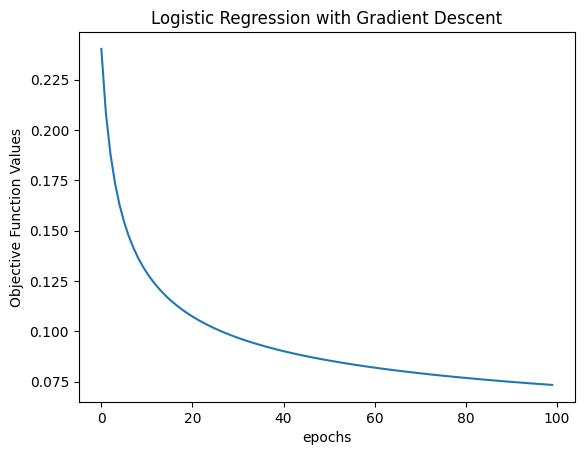

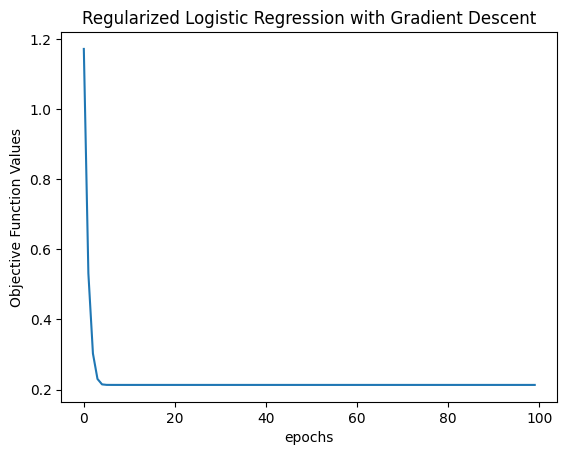

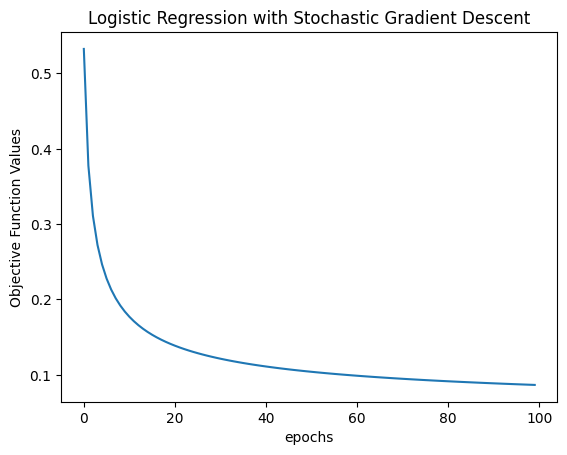

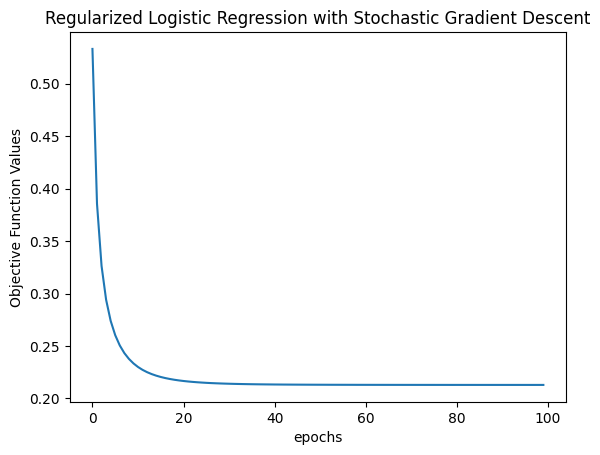

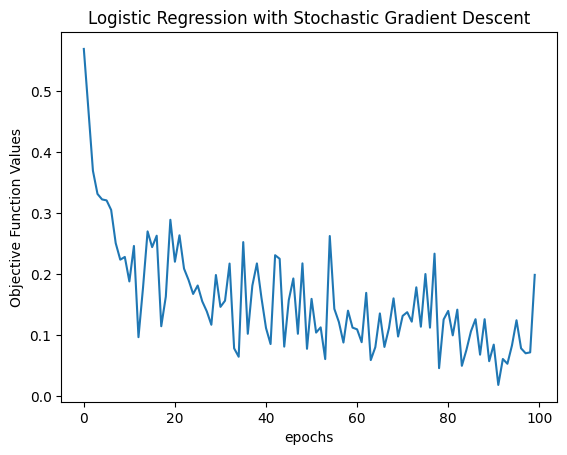

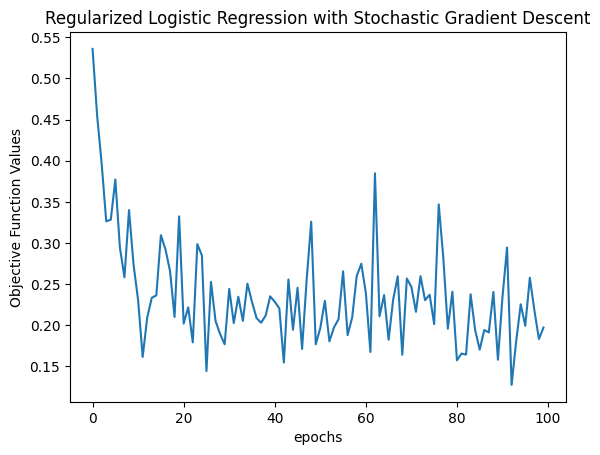

In [214]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(valueExtractor(objVal))
plt.xlabel("epochs")
plt.ylabel("Objective Function Values")
plt.title("Logistic Regression with Gradient Descent")
plt.show()

plt.figure()
plt.plot(valueExtractor(objRegVal))
plt.xlabel("epochs")
plt.ylabel("Objective Function Values")
plt.title("Regularized Logistic Regression with Gradient Descent")
plt.show()

plt.figure()
plt.plot(stocVals)
plt.xlabel("epochs")
plt.ylabel("Objective Function Values")
plt.title("Logistic Regression with Stochastic Gradient Descent")
plt.show()

plt.figure()
plt.plot(stocRegVals)
plt.xlabel("epochs")
plt.ylabel("Objective Function Values")
plt.title("Regularized Logistic Regression with Stochastic Gradient Descent")
plt.show()

plt.figure()
plt.plot(mbgdObjVals)
plt.xlabel("epochs")
plt.ylabel("Objective Function Values")
plt.title("Logistic Regression with Stochastic Gradient Descent")
plt.show()

plt.figure()
plt.plot(mbgdRegObjVals)
plt.xlabel("epochs")
plt.ylabel("Objective Function Values")
plt.title("Regularized Logistic Regression with Stochastic Gradient Descent")
plt.show()

# 5. Prediction
### Compare the training and testing accuracy for logistic regression and regularized logistic regression.

In [215]:
# Predict class label
# Inputs:
#     w: weights: d-by-1 matrix
#     X: data: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    res = np.dot(X, w)
    ans = []
    for elem in res:
        if elem >= 0:
            ans += [1]
        else:
            ans += [-1]
    return ans

In [216]:
# evaluate training error of logistric regression and regularized version
trainPred = predict(objWeight[99], x_train)
print("MSE for Logistic Regression: ", np.mean(y_train - trainPred) ** 2)

trainPred = predict(objRegWeight[99], x_train)
print("MSE for Regularized Logistic Regression: ", np.mean(y_train - trainPred) ** 2)

trainPred = predict(stocWeights[99], x_train)
print("MSE for Logistic Regression with SGD: ", np.mean(y_train - trainPred) ** 2)

trainPred = predict(stocRegWeights[99], x_train)
print("MSE for Regularized Logistic Regression with SGD: ", np.mean(y_train - trainPred) ** 2)

trainPred = predict(mbgdWights[99], x_train)
print("MSE for Logistic Regression with MBGD: ", np.mean(y_train - trainPred) ** 2)

trainPred = predict(mbgdRegWights[99], x_train)
print("MSE for Regularized Logistic Regression with MBGD: ", np.mean(y_train - trainPred) ** 2)

# Rates calculation
print("\nTRAINING ERROR RATES:")
trainPred = predict(objWeight[99], x_train)
accuracy = np.where(trainPred == y_train, 1, 0)
acc = sum(accuracy)/len(accuracy)
print("Logistic Regression: ", acc)

trainPred = predict(objRegWeight[99], x_train)
accuracy = np.where(trainPred == y_train, 1, 0)
acc = sum(accuracy)/len(accuracy)
print("Regularized Logistic Regression: ", acc)

trainPred = predict(stocWeights[99], x_train)
accuracy = np.where(trainPred == y_train, 1, 0)
acc = sum(accuracy)/len(accuracy)
print("Logistic Regression with SGD: ", acc)

trainPred = predict(stocRegWeights[99], x_train)
accuracy = np.where(trainPred == y_train, 1, 0)
acc = sum(accuracy)/len(accuracy)
print("Regularized Logistic Regression with SGD: ", acc)

trainPred = predict(mbgdWights[99], x_train)
accuracy = np.where(trainPred == y_train, 1, 0)
acc = sum(accuracy)/len(accuracy)
print("Logistic Regression with MBGD: ", acc)

trainPred = predict(mbgdRegWights[99], x_train)
accuracy = np.where(trainPred == y_train, 1, 0)
acc = sum(accuracy)/len(accuracy)
print("Regularized Logistic Regression with MBGD: ", acc)

MSE for Logistic Regression:  1.9321338002656683e-05
MSE for Regularized Logistic Regression:  7.728535201062673e-05
MSE for Logistic Regression with SGD:  7.728535201062673e-05
MSE for Regularized Logistic Regression with SGD:  0.0015650283782151914
MSE for Logistic Regression with MBGD:  0.0004830334500664172
MSE for Regularized Logistic Regression with MBGD:  0.0004830334500664172

TRAINING ERROR RATES:
Logistic Regression:  0.9846153846153847
Regularized Logistic Regression:  0.9692307692307692
Logistic Regression with SGD:  0.9208791208791208
Regularized Logistic Regression with SGD:  0.9406593406593406
Logistic Regression with MBGD:  0.9714285714285714
Regularized Logistic Regression with MBGD:  0.967032967032967


In [217]:
# evaluate testing error of logistric regression and regularized version
testPred = predict(objWeight[99], x_test)
print("MSE for Logistic Regression: ", np.mean((testPred - y_test) ** 2))

testPred = predict(objRegWeight[99], x_test)
print("MSE for Regularized Logistic Regression: ", np.mean((testPred - y_test) ** 2))

trainPred = predict(stocWeights[99], x_test)
print("MSE for Logistic Regression with SGD: ", np.mean(y_test - trainPred) ** 2)

trainPred = predict(stocRegWeights[99], x_test)
print("MSE for Regularized Logistic Regression with SGD: ", np.mean(y_test - trainPred) ** 2)

trainPred = predict(mbgdWights[99], x_test)
print("MSE for Logistic Regression with MBGD: ", np.mean(y_test - trainPred) ** 2)

trainPred = predict(mbgdRegWights[99], x_test)
print("MSE for Regularized Logistic Regression with MBGD: ", np.mean(y_test - trainPred) ** 2)

# Rates calculation
print("\nTESTING ERROR RATES:")
y_pred = predict(objWeight[99], x_test)
accuracy = np.where(y_pred == y_test, 1, 0)
acc = sum(accuracy)/len(accuracy)
print("Logistic Regression: " + str(acc))

y_pred = predict(objRegWeight[99], x_test)
accuracy = np.where(y_pred == y_test, 1, 0)
acc = sum(accuracy)/len(accuracy)
print("Regularized Logistic Regression: ", acc)

y_pred = predict(stocWeights[99], x_test)
accuracy = np.where(y_pred == y_test, 1, 0)
acc = sum(accuracy)/len(accuracy)
print("Logistic Regression with SGD: ", acc)

y_pred = predict(stocRegWeights[99], x_test)
accuracy = np.where(y_pred == y_test, 1, 0)
acc = sum(accuracy)/len(accuracy)
print("Regularized Logistic Regression with SGD: ", acc)

y_pred = predict(mbgdWights[99], x_test)
accuracy = np.where(y_pred == y_test, 1, 0)
acc = sum(accuracy)/len(accuracy)
print("Logistic Regression with MBGD: ", acc)

y_pred = predict(mbgdRegWights[99], x_test)
accuracy = np.where(y_pred == y_test, 1, 0)
acc = sum(accuracy)/len(accuracy)
print("Regularized Logistic Regression with MBGD: ", acc)

MSE for Logistic Regression:  0.03508771929824561
MSE for Regularized Logistic Regression:  0.07017543859649122
MSE for Logistic Regression with SGD:  0.007694675284702985
MSE for Regularized Logistic Regression with SGD:  0.0027700831024930744
MSE for Logistic Regression with MBGD:  0.0
MSE for Regularized Logistic Regression with MBGD:  0.0

TESTING ERROR RATES:
Logistic Regression: 0.9912280701754386
Regularized Logistic Regression:  0.9824561403508771
Logistic Regression with SGD:  0.9035087719298246
Regularized Logistic Regression with SGD:  0.9385964912280702
Logistic Regression with MBGD:  0.9824561403508771
Regularized Logistic Regression with MBGD:  0.9824561403508771


# 6. Parameters tuning

### In this section, you may try different combinations of parameters (regularization value, learning rate, etc) to see their effects on the model. (Open ended question)

In [222]:
# Logistic Regression with Gradient Descent Tuning
bestGradDescLearnRate = 0
bestGradDescAccuracy = 0
for i in range(0, 40):
    var1, var2 = gradient_descent(x_train, y_train, 0, 0.25 * i, np.zeros((30, 1)))
    yPred = predict(var1[99], x_test)
    accuracy_ = np.where(yPred == y_test, 1, 0)
    acc_ = sum(accuracy_)/len(accuracy_)
    if (acc_ > bestGradDescAccuracy):
        bestGradDescLearnRate = 0.25 * i
        bestGradDescAccuracy = acc_
print("Optimal Learning Rate for Gradient Descent is Approximately: ", bestGradDescLearnRate)
print("Optimal Accuracy for Gradient Descent is Approximately: ", bestGradDescAccuracy)

# Logistic Regression with Stochastic Gradient Descent Tuning
bestGradDescLearnRate = 0
bestGradDescAccuracy = 0
for i in range(0, 40):
    var1, var2 = sgd(x_train, y_train, 0, 0.25 * i, np.zeros(30))
    yPred = predict(var1[99], x_test)
    accuracy_ = np.where(yPred == y_test, 1, 0)
    acc_ = sum(accuracy_)/len(accuracy_)
    if (acc_ > bestGradDescAccuracy):
        bestGradDescLearnRate = 0.25 * i
        bestGradDescAccuracy = acc_
print("Optimal Learning Rate for Gradient Descent is Approximately: ", bestGradDescLearnRate)
print("Optimal Accuracy for Gradient Descent is Approximately: ", bestGradDescAccuracy)

# Regularized Logistic Regression with Gradient Descent Tuning
bestGradDescLearnRate = 0
bestGradDescAccuracy = 0
for i in range(0, 20):
    var1, var2 = gradient_descent(x_train, y_train, 0.1 * i, 0.5, np.zeros((30, 1)))
    yPred = predict(var1[99], x_test)
    accuracy_ = np.where(yPred == y_test, 1, 0)
    acc_ = sum(accuracy_)/len(accuracy_)
    if (acc_ > bestGradDescAccuracy):
        bestGradDescLearnRate = 0.25 * i
        bestGradDescAccuracy = acc_
print("Optimal Lambda for Gradient Descent is Approximately: ", bestGradDescLearnRate)
print("Optimal Accuracy for Gradient Descent is Approximately: ", bestGradDescAccuracy)

Optimal Learning Rate for Gradient Descent is Approximately:  0.5
Optimal Accuracy for Gradient Descent is Approximately:  0.9912280701754386


/var/folders/gn/18tv_xq900g6n2t164d51mvh0000gn/T/ipykernel_38960/2089152773.py:12: RuntimeWarning: overflow encountered in exp
  return (np.log(1 + np.exp(-1 * yi * np.dot(xi.T, w))) + ((lam / 2) * np.dot(w.T, w))), ((-1 * yi * xi) / (1 + np.exp(yi * np.dot(xi.T, w)))) + (lam * w)


Optimal Learning Rate for Gradient Descent is Approximately:  1.25
Optimal Accuracy for Gradient Descent is Approximately:  0.9824561403508771
Optimal Lambda for Gradient Descent is Approximately:  0.0
Optimal Accuracy for Gradient Descent is Approximately:  0.9912280701754386
